# ⭐

### 🔴 1. Imports

In [1]:
# import the necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import imutils
from imutils.video import VideoStream
from imutils.video import FileVideoStream
import time
import cv2
import time
import matplotlib.pyplot as plt
from tracker_counter import *
from PIL import Image
from datetime import datetime


import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

### 🔴 2. Load Classifier

TODO: Find better classifiers for classifying moving faces </br>
https://github.com/J-Douglas/Face-Mask-Detection

In [2]:
choose = ['YOUTUBE', 'DENSENET']

classifier = 'YOUTUBE'

if classifier == 'YOUTUBE':
    classifier = tf.keras.models.load_model('CLASSIFIERS/youtube_20epoch.h5')

elif classifier == 'DENSENET':
    classifier = tf.keras.models.load_model('densenet12.h5')

### 🔴 3. Load Detector

In [3]:
choose = ['CAFFE', 'YOLO', 'OTHER']

detector = 'CAFFE'

if detector == 'CAFFE':
    # load our serialized face detector model from disk
    prototxtPath = r"DETECTORS/ssd_caffee/deploy.prototxt" # configurations file 
    weightsPath = r"DETECTORS/ssd_caffee/res10_300x300_ssd_iter_140000.caffemodel" # weights file
    detector = cv2.dnn.readNet(prototxtPath, weightsPath) # load saved model
    
elif detector == 'YOLO':
    from yoloface import face_analysis
    detector=face_analysis()    #  Auto Download a large weight files from Google Drive.
                                #  only first time.
                                #  Automatically  create folder .yoloface on cwd.
elif detector == 'OTHER':
    pass

### 🔴 4. Detect Classify

In [4]:
def detect_and_classify(frame, detector, classifier):
    # detect faces in frame and perform mask classification
    # TODO: Change RGB Tuple
    # turn frame into blob (essentially preprocessing: 1. mean subtraction, 2. scaling, 3. optionally channel swapping)
    RGB = (104.0, 177.0, 123.0) # Consider changing. Read the following under "Deep Learning and Mean Subtraction for intuition: https://pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
    pixels = 224
    blob = cv2.dnn.blobFromImage(frame, scalefactor=1.0, size=(pixels, pixels), mean=RGB)
    
    '''
    DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION 
    DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION 
    DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION 
    '''
    
        
    '''
    # Unique code for YOLO face detector
    _, box, confidence = detector.face_detection(frame_arr=frame,frame_status=True,model='tiny')
    #output_frame = detector.show_output(frame,box,frame_status=True)
    num_of_detections = len(box)
    
    # initialise list of faces, their locations, list of predictions for our mask classifier, rectangles list for tracking
    faces = []
    locs = []
    preds = []
    rects = [] 

    
    # loop over all face detections
    for i in range(num_of_detections):
        
        # Live Counter
        num_of_masked = 0
        num_of_unmasked = 0
        num_of_uncertain = 0
        

        # filter out weak detections by ensuring the confidence is  greater than the minimum confidence
        # TODO: optimise this number
        if confidence[i] > 0.:
            
            # compute the (x, y)-coordinates of the bounding box for the object 
            rect = np.array(box[i])
            rect[2], rect[3] = rect[0]+rect[3], rect[1]+rect[2] # change to (startX, startY, endX, endY) format
            rects.append(rect.astype('int'))
            (startX, startY, endX, endY) = rect.astype("int")
    
    # and the rest is the same
    '''
    
      
    
    '''
    TODO: Understand
    pass the blob through the network and obtain the face detections in the form of a blob. Current shape: (1, 1, 200, 7).
    1st dim: ?
    2nd dim: ?
    3rd dim: number of detections
    4th dim: (?, ?, confidence, startX %, startY %, endX %, endY %)
    The output is a 200x7 "array of heatmaps", the probability of a face being in location x, y. 
    I think 200 (the third value) is the number of face detections. I.e. 200 faces where detected each with a different probability of being a face. 
    '''
    
    
    detector.setInput(blob)
    detections = detector.forward()
    num_of_detections = detections.shape[2]

    

    # initialise list of faces, their locations, list of predictions for our mask classifier, rectangles list for tracking
    faces = []
    locs = []
    preds = []
    rects = []
    
    # loop over all face detections
    for i in range(num_of_detections):
        
        # Live Counter
        num_of_masked = 0
        num_of_unmasked = 0
        num_of_uncertain = 0
        
        # extract the confidence (probability) in the detection
        # The 1st and 2nd seem to be either 0 or 1. 
        # The last 4 are boundaries of box respectively: startX %, startY %, endX %, endY %. For example 30% of width to 60% of width and 10% of height to 40% of height of image. 
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is  greater than the minimum confidence
        if confidence > 0.3:
            
            # compute the (x, y)-coordinates of the bounding box for the object 
            box = detections[0, 0, i, 3:7] * np.array([W, H, W, H])
            rects.append(box.astype('int'))
            (startX, startY, endX, endY) = box.astype("int")
    
    
  

            # ensure the bounding boxes fall within the dimensions of the frame 
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(W - 1, endX), min(H - 1, endY))

            # Extract Face 
            face = frame[startY:endY, startX:endX]                          # 1. extract the face region of interest (ROI) 
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)                    # 2. convert it from BGR to RGB channel ordering 
            face = cv2.resize(face, (224, 224))                             # 3. resize it to 224x224 
            face = tf.keras.preprocessing.image.img_to_array(face)          # 4. preprocess it for the mask classifier
            face = tf.keras.applications.mobilenet_v2.preprocess_input(face)

            # append face and bounding box to lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference make batch predictions on *all* faces at the same time rather than one-by-one predictions in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = classifier.predict(faces, batch_size=32, verbose=0)
  


    return locs, preds, rects

### 🔴 5. TrackerCounter

In [5]:
mydict = {5: '43', 2: '25'}
len(mydict)

2

In [6]:
import math
from random import randrange

class TrackerCounter:
    
    people_count = 0
    mask_count = 0
    nomask_count = 0
    uncertain_count = 0
    
    def __init__(self):
       
        # Store the center positions of the objects in a dictionary of the form: 
        # id: [cx, cy, has_been_before_boundary, has_been_after_boundary, list_of_up_to_10_label_probs]
        self.center_points = {}
        # ID Count
        # each time a new object id detected, the count will increase by one
        self.id_count = 0


    def update(self, objects_rect, label_probs, W, H, dist_same_obj=100):
        
        # TODO: change name: dist_same_obj. Should be the opposite bc the higher the dist_same_obj the less sensitive it is to false positives.
    
        '''
        object_rect: List of objects' coordinates = [(xstart1, ystart1, xend1, yend1), (xstart2, ystart2, xend2, yend2), ...]
        label_probs: List of objects' label "probabilities" = [-0.9, 0.7, ....]
        w, h: frame width and height
    
        
        dist_same_obj: Added by me
        - It is the maximum eucledian distance from the previous object in order to be considered the same object
        - dist_same_obj determines how far the detection has to be from the old one to be considered a new object. 
        - If dist_same_obj is too low we might get false positives when an object is moving. 
        - It also depends on the amount of pixels so needs different value when resolution changes.
        '''
            
        # List of info of all objects in the frame (this is what the method returns)
        objects_infos = []
        
        # NB: If dist_same_obj is too low then fast moving faces are seen as a new face in each frame and averaging classification is not done OR even worse they are not counted at all (because a new face appears after the boundary)
        # NB: If dist_same_obj is too high then if a face disappears at frame 15 and a new face appears at frame 16 (it is only a problem if this happens in consecutive frames since memory is not implemented i.e. we got 1 frame memory) 
        # then the new face will be seen as the old face and might not be tracked
        # NB: This is very unlikely to be an issue when memory = 1 as it is now so it is a lot safer to have a high dist_same_obj than a low one. 
        dist_same_obj=(W+H)/10
        
        # Loop through all faces and their labels
        counter=1 # this makes sure two or more faces are not labelled the same 
        
        for rect, prob, counter in zip(objects_rect, label_probs, range(len(objects_rect))):
            xstart, ystart, xend, yend = rect
            # Get center point of new object
            cx = (xstart + xend) // 2
            cy = (ystart + yend) // 2 
            
            
            '''Find out if same face was detected'''
            same_object_detected = False
            # For all objects in previous frame 
            for face_id, pt in self.center_points.items():
                
                # calculate eucledian distance from previously detected face
                dist = math.hypot(cx - pt[0], cy - pt[1])
                
                # 1st condition: If it is the same object (ditsance < dist_same_obj) update previous objects location to this one's (keeps the object id). 
                # 2nd condition: But create a NEW object if the previous frames object's were fewer than this frame's (otherwise if dist < dist_same_obj for the same object then theyll share IDs) and 
                # youll get the bug where when 2 people show up it is Face 1 and Face 1 as if they are the same face. So current # of objects has to be <= previous number of objects to match to previous objects which makes sense. 
                if dist < dist_same_obj and counter<=len(self.center_points):
                    self.center_points[face_id][0] = cx      # update center x
                    self.center_points[face_id][1] = cy      # update center y 
                    
                    # Append classification probability to this face's classification history
                    frames_to_avg_over = 10
                    if len(pt[4]) < frames_to_avg_over:
                        self.center_points[face_id][4].append(prob)
                    # If there are already 10 probabilities in the list then replace one at random (because the code for cycling through them one by one seems too complex in this case)
                    else: 
                        self.center_points[face_id][4][randrange(frames_to_avg_over)] = prob 
                    
                    # Add object info to list to return 
                    objects_infos.append([xstart, ystart, xend, yend, face_id])
                    same_object_detected = True 
                
                    break
                
            '''New face detected'''
            # New object is detected: assign ID to that object
            if same_object_detected == False:
                self.id_count += 1
                self.center_points[self.id_count] = [cx, cy, False, False, [prob]]
                
                
                
                # Add new object to list to return
                objects_infos.append([xstart, ystart, xend, yend, self.id_count])
            
            counter+=1
                    
        # Clean the dictionary by center points to remove IDS not used anymore
        # TODO: Implement Memory
        # TODO: consider running this every 5 frames to fix disappearing face = new face problem. 
        # NB: Making memory > 1 frame might lead to issues with high dist_same_obj that were not there before. See notes on dist_same_obj above. 
        # NB: The benefit of memory though is particularly high if faces tend to disappear the frame before the boundary is crossed and then are never counted. 
        # If that's not the case then it should be =1
        new_center_points = {}
        for object_info in objects_infos:
            _, _, _, _, object_id = object_info
            center = self.center_points[object_id]
            new_center_points[object_id] = center
        
        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        
        
        
        # People counter 
        for face_id, pt in self.center_points.items():
            # Note if object has been in the top 80% of the frame
            if pt[0] > left_boundary_line:
                self.center_points[face_id][2] = True
            
            # Note if the object 
            # 1. has been detected after the boundary
            # 2. has been detected before the boundary (can remove this condition, it is just to ensure that someone who appears from the bottom is not counted) and
            # 3. has never been counted before 
            # Then update it to having been counted and increase people count by 1 
            # NB: pt[0] = xcenter, pt[1] = ycenter
            if (pt[0] < left_boundary_line) and (pt[2] == True) and pt[3] == False:
                self.center_points[face_id][3] = True
                self.people_count += 1 
                
                
                div = 3 # the larger div is the smaller the perpetrator frame will be 
                

                # labeled count
                avg_prob = np.mean(pt[4])

                if avg_prob > 0.5 + uncertain_interval:
                    self.mask_count += 1
                    
                    # TODO: Only for testing, remove 
                    # Save and display image of masked person
                    print(f'MASK ({current_time})')
                    detection_data.append(['mask', current_time])
                    # Catch exception where face is moving too fast and towards bottom left and perpetrator[0] or perpetrator[1] (width or height or both) ends up being 0.
                    perpetrator=frame[0:H, 0:left_boundary_line + W//5]
                    perpetrator = cv2.cvtColor(perpetrator, cv2.COLOR_BGR2RGB)
                    perpetrator = Image.fromarray(perpetrator, 'RGB')
                    plt.imshow(perpetrator)
                    plt.show()
                    
                elif avg_prob < -0.5 - uncertain_interval:
                    self.nomask_count += 1
                    
                    # Save and display image of unmasked person
                    print(f'NO MASK ({current_time})')
                    detection_data.append(['no_mask', current_time])
                    # Catch exception where face is moving too fast and towards bottom left and perpetrator[0] or perpetrator[1] (width or height or both) ends up being 0.
                    perpetrator=frame[0:H, 0:left_boundary_line + W//5]
                    perpetrator = cv2.cvtColor(perpetrator, cv2.COLOR_BGR2RGB)
                    perpetrator = Image.fromarray(perpetrator, 'RGB')
                    plt.imshow(perpetrator)
                    plt.show()
                    
                    
#                     #perpetrator.save('perpetrator.png')
#                     logo = cv2.resize(perpetrator, (w//5, h//5))
#                     # Create a mask of logo
#                     img2gray = cv2.cvtColor(logo, cv2.COLOR_BGR2GRAY)
#                     ret, ma = cv2.threshold(img2gray, 1, 255, cv2.THRESH_BINARY)
#                     roi = frame[0:h, 0:w]
#                     roi[np.where(ma)] = 0
#                     roi += logo

                    
                else:
                    self.uncertain_count += 1
                    
                    # Save and display image of potentially unmasked person
                    print(f'UNCERTAIN ({current_time})')
                    detection_data.append(['uncertain', current_time])
                    # Catch exception where face is moving too fast and towards bottom left and perpetrator[1] (the height of the image) ends up being 0. If it happens a lot the line can be moved above 80%
                    perpetrator=frame[0:H, 0:left_boundary_line + W//5]
                    perpetrator = cv2.cvtColor(perpetrator, cv2.COLOR_BGR2RGB)
                    perpetrator = Image.fromarray(perpetrator, 'RGB')
                    plt.imshow(perpetrator)
                    plt.show()
                                                

                        
                        
        
        return objects_infos





### 🔴 6. Video

In [7]:
#vs = VideoStream(src=0).start()
vs = FileVideoStream('3_side.mp4').start()

Test 1: BASELINE
NO MASK (2022-08-19 19:15:34)


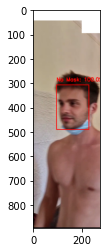

NO MASK (2022-08-19 19:15:44)


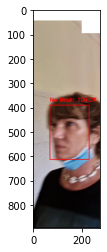

NO MASK (2022-08-19 19:15:51)


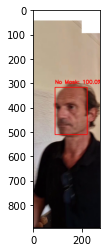

NO MASK (2022-08-19 19:15:59)


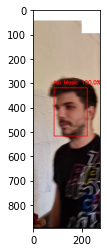

NO MASK (2022-08-19 19:16:05)


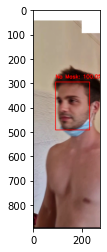

NO MASK (2022-08-19 19:16:17)


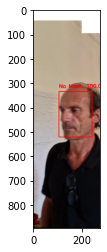

NO MASK (2022-08-19 19:16:29)


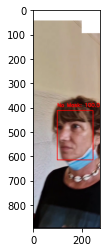

NO MASK (2022-08-19 19:16:38)


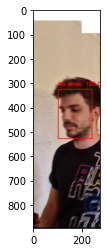

MASK (2022-08-19 19:16:45)


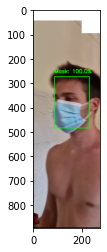

MASK (2022-08-19 19:16:55)


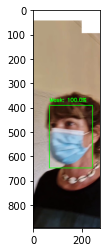

MASK (2022-08-19 19:17:03)


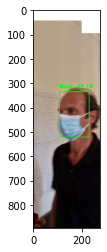

MASK (2022-08-19 19:17:10)


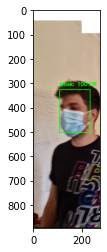

MASK (2022-08-19 19:17:26)


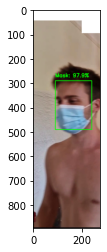

MASK (2022-08-19 19:17:35)


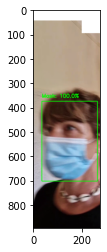

MASK (2022-08-19 19:17:41)


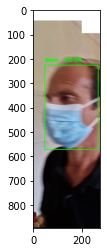

MASK (2022-08-19 19:17:51)


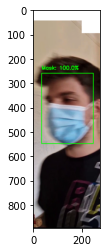

16 people.
8 mask.
8 no_mask.
0 uncertain.


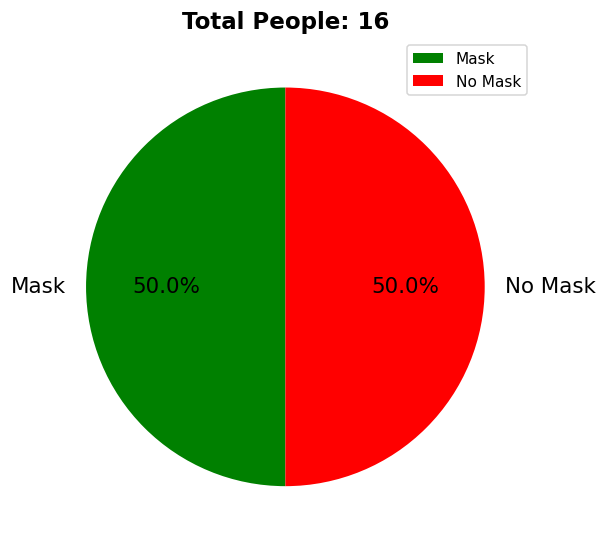

In [8]:
print('Test 1: BASELINE')
vs = FileVideoStream('1_baseline.mp4').start()
tracker = TrackerCounter()

# Initialise total tracked faces to 0 
idd = 0


W = 500
left_boundary_line = int(0.35*W)

# Count fps initialise
fps_start_time = 0
fps = 0

# initialise csv file with collected data
detection_data = []


# loop over the frames from the video stream
while True:
    
    frame = vs.read()
    
    # ONLY FOR VIDEO FILES: check if video file has ended has ended
    if type(frame).__module__!= 'numpy':
        break
    
    
    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''
    
    # Resize the frame
    # NB: cv2.resize lets you choose height and width, imutils.resize only lets you choose width but preserves ratio
    # frame = cv2.resize(frame, dsize=(x, y))
    
    frame = imutils.resize(frame, width=W)
    H, W = frame.shape[:2] # used in detect_and_classify also
    
    
    # Calculate ideal font scale
    scale = 0.030                      # this value can be from 0 to 1 (0,1] to change the size of the text relative to the image
    ideal_font_size = min(W,H)/(25/scale)
    
    # Define box locations
    yy = int(ideal_font_size*35)
    box1start = np.array((0, 0))
    box1end = np.array((int(0.40*W), yy*2))
    box2start = np.array((int(0.40*W), 0))
    box2end = np.array((W, int(yy*4.5)))
    
    cv2.rectangle(frame, pt1=box1start, pt2=box1end, color=(255, 255, 255), thickness=-1)
    cv2.rectangle(frame, pt1=box2start, pt2=box2end, color=(255, 255, 255), thickness=-1)
    
    # TODO: add border to box 

    
    '''
    DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY 
    DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY 
    '''
    
    # Detect and Classify for each frame
    locs, preds, rects = detect_and_classify(frame, detector, classifier)

    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''
    
    label_probs = [] # This is for tracker_counter to average over multiple classifications
    # Live Counter
    num_of_masked = 0
    num_of_unmasked = 0
    num_of_uncertain = 0
    
    # Define classification uncertainty interval
    uncertain_interval = 0. # 0.1 is 10% so 40-60 
    
    # loop over face locations and mask predictions
    for box, pred in zip(locs, preds):
        
        # unpack the bounding box and predictions
        startX, startY, endX, endY = box
        mask, no_mask = pred
        
        # 1. Determine the class label 2. Add colour (BGR)
        if mask >= 0.5 + uncertain_interval:
            label = 'Mask'
            colour = (0, 255, 0)
            num_of_masked +=1
            label_probs.append(mask)
            
        elif no_mask >= 0.5 + uncertain_interval:
            label = 'No Mask'
            colour = (0, 0, 255)
            num_of_unmasked +=1
            label_probs.append(-no_mask)
            
        elif (mask >= 0.5) and (mask <= 0.5 + uncertain_interval):
            label = 'Uncertain'
            colour = (0, 255, 255)
            num_of_uncertain +=1
            # for tracker_counter to average over 
            label_probs.append(mask)
            
        elif (no_mask >= 0.5) and (no_mask <= 0.5 + uncertain_interval):
            label = 'Uncertain'
            colour = (0, 255, 255)
            num_of_uncertain +=1
            # for tracker_counter to average over 
            label_probs.append(-no_mask)
        
        # probability and text to display
        probability = max(mask, no_mask) * 100
        label_text = f'{label}: {probability:.1f}%'
        
        
        # 1. Display label  
        cv2.putText(img=frame, text=label_text, org=(startX, startY - 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=colour, thickness=2)
        # 2. Display bounding box
        cv2.rectangle(img=frame, pt1=(startX, startY), pt2=(endX, endY), color=colour, thickness=2)
        

    '''
    COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER
    COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER 
    '''
    
    
    # objects_info = [object1_info, object2_info, ...] where object_info = [Xstart, Ystart, Xend, Yend, id_of_object]
    objects_info = tracker.update(rects, label_probs, W, H, dist_same_obj=(W + H / 14))
        
        
    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''  
    
    # for all objects
    for object_info in objects_info: 
        Xstart, Ystart, Xend, Yend, idd = object_info
        
        # VISUALS        
        # Text
        # ID of face (TODO: get rid of this eventually)
        cv2.putText(img=frame, text=f'Face {idd}', org=(Xstart, Ystart-40), fontScale=1.4, fontFace=cv2.FONT_HERSHEY_PLAIN, color=(155, 149, 24), thickness=2)
    
    
    # Calculate fps
    fps_end_time = time.time()
    time_diff = fps_end_time - fps_start_time
    fps = int(1/time_diff)
    fps = f'FPS: {fps}'
    fps_start_time = fps_end_time
    
    # Calculate current time
    current_time = str(datetime.now())[:-7]
    
    # VISUALS: Display FPS and Current Time
    # TODO: Get rid of this eventually.Think of potential use cases
    cv2.putText(img=frame, text=current_time, org=(box1start[0] + box1start[0]//14, yy), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=2)
    cv2.putText(img=frame, text=fps, org=(box1start[0] + box1start[0]//14, int(yy*1.8)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=2)
    
    # VISUALS: Display boundary line
    cv2.line(img=frame, pt1=(left_boundary_line, 0), pt2=(left_boundary_line, H), color=(45, 174, 102), thickness=5) 
    
    # VISUALS: Display live people counter 
    cv2.putText(img=frame, text=f'People Count: {tracker.people_count}', org=(box2start[0] + box2start[0]//15, yy), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 0, 0), thickness=2)
    percent_masked = 0
    percent_unmasked = 0
    percent_uncertain = 0
    if tracker.people_count != 0:
        percent_masked = np.round(tracker.mask_count / tracker.people_count * 100, 1) 
        percent_unmasked = np.round(tracker.nomask_count / tracker.people_count * 100, 1) 
        percent_uncertain = np.round(tracker.uncertain_count / tracker.people_count * 100, 1) 
    cv2.putText(img=frame, text=f'Masked:       {tracker.mask_count} ({percent_masked}%)', org=(box2start[0] + box2start[0]//15, yy*2), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 155, 0), thickness=2)
    cv2.putText(img=frame, text=f'Unmasked:    {tracker.nomask_count} ({percent_unmasked}%)', org=(box2start[0] + box2start[0]//15, int(yy*3)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 0, 155), thickness=2)
    cv2.putText(img=frame, text=f'Uncertain:     {tracker.uncertain_count} ({percent_uncertain}%)', org=(box2start[0] + box2start[0]//15, int(yy*4)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 155, 155), thickness=2)

    '''
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    '''
            
    # Show the output frame in real-time
    cv2.imshow("Frame", frame)

    # Terminate if `q` is pressed. waitKey(0): keeps image still until a key is pressed. waitKey(x) it will wait x miliseconds each frame
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
        
''' 
EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS 
EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS 
'''

        

'''Export csv file and summarise results'''
detection_data = pd.DataFrame(data=detection_data, columns=['Label', 'Datetime'])
detection_data.to_csv('detection_data.csv', index=False)

# Summarise and visualise results
num_of_people = detection_data.shape[0]
if num_of_people > 0:
    mask = detection_data[detection_data.Label == 'mask'].shape[0]
    no_mask = detection_data[detection_data.Label == 'no_mask'].shape[0]
    uncertain = detection_data[detection_data.Label == 'uncertain'].shape[0]

    print(f'{num_of_people} people.')
    print(f'{mask} mask.')
    print(f'{no_mask} no_mask.')
    print(f'{uncertain} uncertain.')


    # PIE CHART
    dpi=110
    fig = plt.figure(figsize=(8, 6), dpi=dpi)

    if uncertain != 0:
        plt.pie(x=[mask, no_mask, uncertain], labels=['Mask', 'No Mask', 'Uncertain'], colors=['green', 'red', 'yellow'], startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14})
    if uncertain == 0: 
        plt.pie(x=[mask, no_mask], labels=['Mask', 'No Mask'], colors=['green', 'red'], startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14})

    plt.title(f'Total People: {num_of_people}', fontweight='bold', fontsize=15)
    plt.legend()
    plt.show()

    fig.savefig(f'face_covering_pie_chart.png', dpi = dpi)

else:
    print('No people detected.')

        
# # Cleanup
#vs.stop()
#cv2.destroyAllWindows()


Test 2: SPEED
NO MASK (2022-08-19 19:18:03)


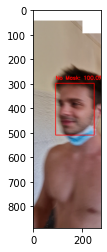

NO MASK (2022-08-19 19:18:10)


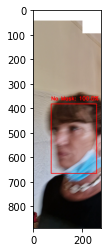

NO MASK (2022-08-19 19:18:17)


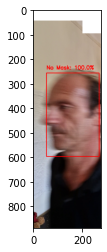

NO MASK (2022-08-19 19:18:23)


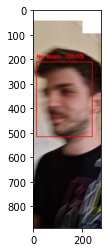

NO MASK (2022-08-19 19:18:36)


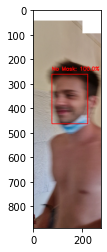

NO MASK (2022-08-19 19:18:43)


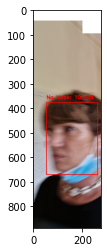

NO MASK (2022-08-19 19:18:48)


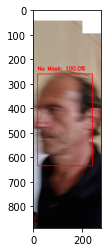

NO MASK (2022-08-19 19:18:53)


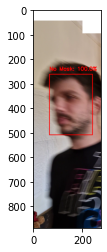

UNCERTAIN (2022-08-19 19:19:06)


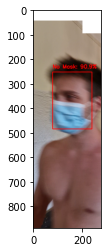

MASK (2022-08-19 19:19:12)


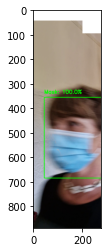

MASK (2022-08-19 19:19:17)


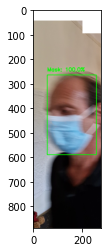

MASK (2022-08-19 19:19:22)


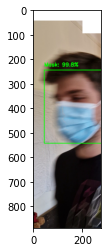

UNCERTAIN (2022-08-19 19:19:35)


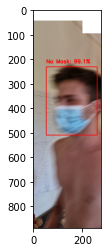

MASK (2022-08-19 19:19:40)


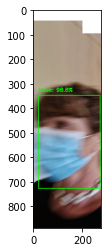

MASK (2022-08-19 19:19:45)


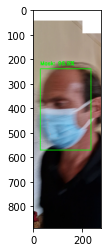

MASK (2022-08-19 19:19:50)


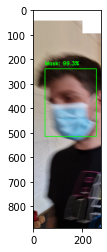

16 people.
6 mask.
8 no_mask.
2 uncertain.


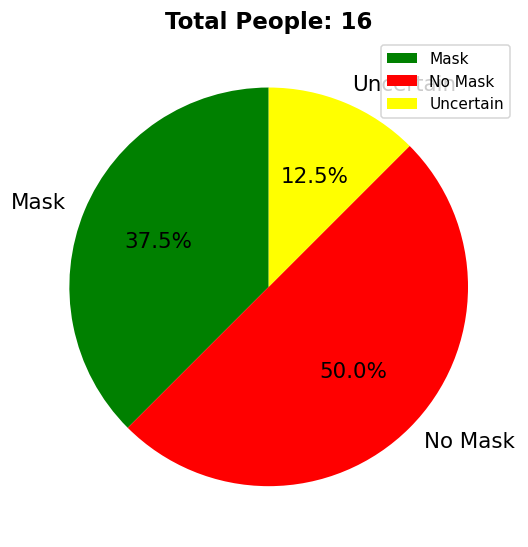

In [9]:
tracker = TrackerCounter()
print('Test 2: SPEED')
vs = FileVideoStream('2_speed.mp4').start()
# Initialise total tracked faces to 0 
idd = 0


W = 500
left_boundary_line = int(0.35*W)

# Count fps initialise
fps_start_time = 0
fps = 0

# initialise csv file with collected data
detection_data = []


# loop over the frames from the video stream
while True:
    
    frame = vs.read()
    
    # ONLY FOR VIDEO FILES: check if video file has ended has ended
    if type(frame).__module__!= 'numpy':
        break
    
    
    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''
    
    # Resize the frame
    # NB: cv2.resize lets you choose height and width, imutils.resize only lets you choose width but preserves ratio
    # frame = cv2.resize(frame, dsize=(x, y))
    
    frame = imutils.resize(frame, width=W)
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    H, W = frame.shape[:2] # used in detect_and_classify also
    
    
    # Calculate ideal font scale
    scale = 0.030                      # this value can be from 0 to 1 (0,1] to change the size of the text relative to the image
    ideal_font_size = min(W,H)/(25/scale)
    
    # Define box locations
    yy = int(ideal_font_size*35)
    box1start = np.array((0, 0))
    box1end = np.array((int(0.40*W), yy*2))
    box2start = np.array((int(0.40*W), 0))
    box2end = np.array((W, int(yy*4.5)))
    
    cv2.rectangle(frame, pt1=box1start, pt2=box1end, color=(255, 255, 255), thickness=-1)
    cv2.rectangle(frame, pt1=box2start, pt2=box2end, color=(255, 255, 255), thickness=-1)
    
    # TODO: add border to box 

    
    '''
    DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY 
    DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY 
    '''
    
    # Detect and Classify for each frame
    locs, preds, rects = detect_and_classify(frame, detector, classifier)

    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''
    
    label_probs = [] # This is for tracker_counter to average over multiple classifications
    # Live Counter
    num_of_masked = 0
    num_of_unmasked = 0
    num_of_uncertain = 0
    
    # Define classification uncertainty interval
    uncertain_interval = 0. # 0.1 is 10% so 40-60 
    
    # loop over face locations and mask predictions
    for box, pred in zip(locs, preds):
        
        # unpack the bounding box and predictions
        startX, startY, endX, endY = box
        mask, no_mask = pred
        
        # 1. Determine the class label 2. Add colour (BGR)
        if mask >= 0.5 + uncertain_interval:
            label = 'Mask'
            colour = (0, 255, 0)
            num_of_masked +=1
            label_probs.append(mask)
            
        elif no_mask >= 0.5 + uncertain_interval:
            label = 'No Mask'
            colour = (0, 0, 255)
            num_of_unmasked +=1
            label_probs.append(-no_mask)
            
        elif (mask >= 0.5) and (mask <= 0.5 + uncertain_interval):
            label = 'Uncertain'
            colour = (0, 255, 255)
            num_of_uncertain +=1
            # for tracker_counter to average over 
            label_probs.append(mask)
            
        elif (no_mask >= 0.5) and (no_mask <= 0.5 + uncertain_interval):
            label = 'Uncertain'
            colour = (0, 255, 255)
            num_of_uncertain +=1
            # for tracker_counter to average over 
            label_probs.append(-no_mask)
        
        # probability and text to display
        probability = max(mask, no_mask) * 100
        label_text = f'{label}: {probability:.1f}%'
        
        
        # 1. Display label  
        cv2.putText(img=frame, text=label_text, org=(startX, startY - 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=colour, thickness=2)
        # 2. Display bounding box
        cv2.rectangle(img=frame, pt1=(startX, startY), pt2=(endX, endY), color=colour, thickness=2)
        

    '''
    COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER
    COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER 
    '''
    
    
    # objects_info = [object1_info, object2_info, ...] where object_info = [Xstart, Ystart, Xend, Yend, id_of_object]
    objects_info = tracker.update(rects, label_probs, W, H, dist_same_obj=(W + H / 14))
        
        
    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''  
    
    # for all objects
    for object_info in objects_info: 
        Xstart, Ystart, Xend, Yend, idd = object_info
        
        # VISUALS        
        # Text
        # ID of face (TODO: get rid of this eventually)
        cv2.putText(img=frame, text=f'Face {idd}', org=(Xstart, Ystart-40), fontScale=1.4, fontFace=cv2.FONT_HERSHEY_PLAIN, color=(155, 149, 24), thickness=2)
    
    
    # Calculate fps
    fps_end_time = time.time()
    time_diff = fps_end_time - fps_start_time
    fps = int(1/time_diff)
    fps = f'FPS: {fps}'
    fps_start_time = fps_end_time
    
    # Calculate current time
    current_time = str(datetime.now())[:-7]
    
    # VISUALS: Display FPS and Current Time
    # TODO: Get rid of this eventually.Think of potential use cases
    cv2.putText(img=frame, text=current_time, org=(box1start[0] + box1start[0]//14, yy), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=2)
    cv2.putText(img=frame, text=fps, org=(box1start[0] + box1start[0]//14, int(yy*1.8)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=2)
    
    # VISUALS: Display boundary line
    cv2.line(img=frame, pt1=(left_boundary_line, 0), pt2=(left_boundary_line, H), color=(45, 174, 102), thickness=5) 
    
    # VISUALS: Display live people counter 
    cv2.putText(img=frame, text=f'People Count: {tracker.people_count}', org=(box2start[0] + box2start[0]//15, yy), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 0, 0), thickness=2)
    percent_masked = 0
    percent_unmasked = 0
    percent_uncertain = 0
    if tracker.people_count != 0:
        percent_masked = np.round(tracker.mask_count / tracker.people_count * 100, 1) 
        percent_unmasked = np.round(tracker.nomask_count / tracker.people_count * 100, 1) 
        percent_uncertain = np.round(tracker.uncertain_count / tracker.people_count * 100, 1) 
    cv2.putText(img=frame, text=f'Masked:       {tracker.mask_count} ({percent_masked}%)', org=(box2start[0] + box2start[0]//15, yy*2), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 155, 0), thickness=2)
    cv2.putText(img=frame, text=f'Unmasked:    {tracker.nomask_count} ({percent_unmasked}%)', org=(box2start[0] + box2start[0]//15, int(yy*3)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 0, 155), thickness=2)
    cv2.putText(img=frame, text=f'Uncertain:     {tracker.uncertain_count} ({percent_uncertain}%)', org=(box2start[0] + box2start[0]//15, int(yy*4)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 155, 155), thickness=2)

    '''
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    '''
            
    # Show the output frame in real-time
    cv2.imshow("Frame", frame)

    # Terminate if `q` is pressed. waitKey(0): keeps image still until a key is pressed. waitKey(x) it will wait x miliseconds each frame
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
        
''' 
EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS 
EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS 
'''

        

'''Export csv file and summarise results'''
detection_data = pd.DataFrame(data=detection_data, columns=['Label', 'Datetime'])
detection_data.to_csv('detection_data.csv', index=False)

# Summarise and visualise results
num_of_people = detection_data.shape[0]
if num_of_people > 0:
    mask = detection_data[detection_data.Label == 'mask'].shape[0]
    no_mask = detection_data[detection_data.Label == 'no_mask'].shape[0]
    uncertain = detection_data[detection_data.Label == 'uncertain'].shape[0]

    print(f'{num_of_people} people.')
    print(f'{mask} mask.')
    print(f'{no_mask} no_mask.')
    print(f'{uncertain} uncertain.')


    # PIE CHART
    dpi=110
    fig = plt.figure(figsize=(8, 6), dpi=dpi)

    if uncertain != 0:
        plt.pie(x=[mask, no_mask, uncertain], labels=['Mask', 'No Mask', 'Uncertain'], colors=['green', 'red', 'yellow'], startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14})
    if uncertain == 0: 
        plt.pie(x=[mask, no_mask], labels=['Mask', 'No Mask'], colors=['green', 'red'], startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14})

    plt.title(f'Total People: {num_of_people}', fontweight='bold', fontsize=15)
    plt.legend()
    plt.show()

    fig.savefig(f'face_covering_pie_chart.png', dpi = dpi)

else:
    print('No people detected.')

        
# # Cleanup
#vs.stop()
#cv2.destroyAllWindows()


Test 3: SIDEFACE
NO MASK (2022-08-19 19:20:04)


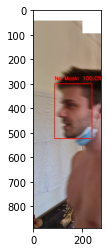

NO MASK (2022-08-19 19:20:12)


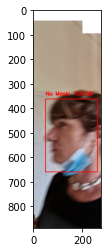

NO MASK (2022-08-19 19:20:22)


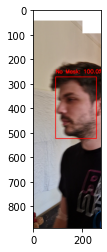

NO MASK (2022-08-19 19:20:41)


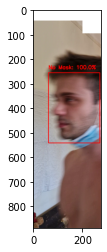

NO MASK (2022-08-19 19:20:48)


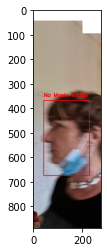

NO MASK (2022-08-19 19:20:55)


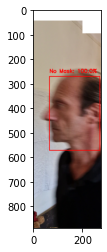

NO MASK (2022-08-19 19:21:01)


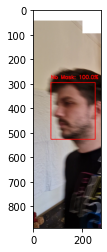

UNCERTAIN (2022-08-19 19:21:18)


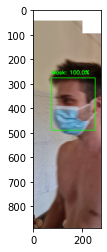

MASK (2022-08-19 19:21:32)


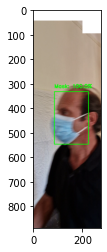

MASK (2022-08-19 19:21:40)


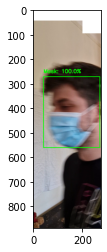

MASK (2022-08-19 19:22:08)


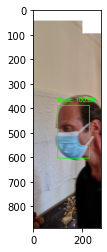

MASK (2022-08-19 19:22:17)


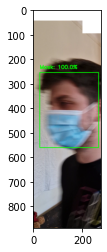

12 people.
4 mask.
7 no_mask.
1 uncertain.


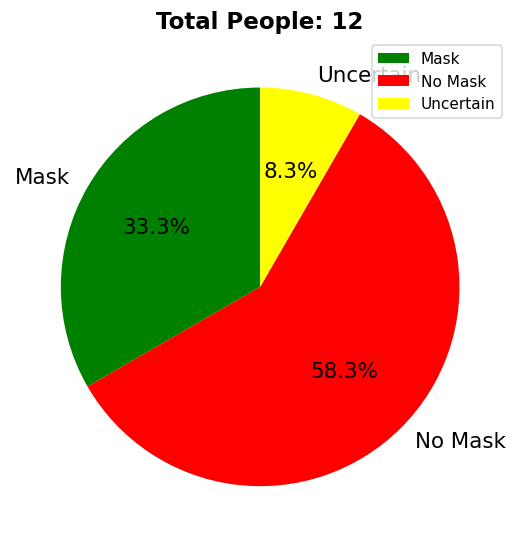

In [10]:
tracker = TrackerCounter()
print('Test 3: SIDEFACE')
vs = FileVideoStream('3_side.mp4').start()

# Initialise total tracked faces to 0 
idd = 0


W = 500
left_boundary_line = int(0.35*W)

# Count fps initialise
fps_start_time = 0
fps = 0

# initialise csv file with collected data
detection_data = []


# loop over the frames from the video stream
while True:
    
    frame = vs.read()
    
    # ONLY FOR VIDEO FILES: check if video file has ended has ended
    if type(frame).__module__!= 'numpy':
        break
    
    
    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''
    
    # Resize the frame
    # NB: cv2.resize lets you choose height and width, imutils.resize only lets you choose width but preserves ratio
    # frame = cv2.resize(frame, dsize=(x, y))
    
    frame = imutils.resize(frame, width=W)
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    H, W = frame.shape[:2] # used in detect_and_classify also
    
    
    # Calculate ideal font scale
    scale = 0.030                      # this value can be from 0 to 1 (0,1] to change the size of the text relative to the image
    ideal_font_size = min(W,H)/(25/scale)
    
    # Define box locations
    yy = int(ideal_font_size*35)
    box1start = np.array((0, 0))
    box1end = np.array((int(0.40*W), yy*2))
    box2start = np.array((int(0.40*W), 0))
    box2end = np.array((W, int(yy*4.5)))
    
    cv2.rectangle(frame, pt1=box1start, pt2=box1end, color=(255, 255, 255), thickness=-1)
    cv2.rectangle(frame, pt1=box2start, pt2=box2end, color=(255, 255, 255), thickness=-1)
    
    # TODO: add border to box 

    
    '''
    DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY 
    DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY 
    '''
    
    # Detect and Classify for each frame
    locs, preds, rects = detect_and_classify(frame, detector, classifier)

    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''
    
    label_probs = [] # This is for tracker_counter to average over multiple classifications
    # Live Counter
    num_of_masked = 0
    num_of_unmasked = 0
    num_of_uncertain = 0
    
    # Define classification uncertainty interval
    uncertain_interval = 0. # 0.1 is 10% so 40-60 
    
    # loop over face locations and mask predictions
    for box, pred in zip(locs, preds):
        
        # unpack the bounding box and predictions
        startX, startY, endX, endY = box
        mask, no_mask = pred
        
        # 1. Determine the class label 2. Add colour (BGR)
        if mask >= 0.5 + uncertain_interval:
            label = 'Mask'
            colour = (0, 255, 0)
            num_of_masked +=1
            label_probs.append(mask)
            
        elif no_mask >= 0.5 + uncertain_interval:
            label = 'No Mask'
            colour = (0, 0, 255)
            num_of_unmasked +=1
            label_probs.append(-no_mask)
            
        elif (mask >= 0.5) and (mask <= 0.5 + uncertain_interval):
            label = 'Uncertain'
            colour = (0, 255, 255)
            num_of_uncertain +=1
            # for tracker_counter to average over 
            label_probs.append(mask)
            
        elif (no_mask >= 0.5) and (no_mask <= 0.5 + uncertain_interval):
            label = 'Uncertain'
            colour = (0, 255, 255)
            num_of_uncertain +=1
            # for tracker_counter to average over 
            label_probs.append(-no_mask)
        
        # probability and text to display
        probability = max(mask, no_mask) * 100
        label_text = f'{label}: {probability:.1f}%'
        
        
        # 1. Display label  
        cv2.putText(img=frame, text=label_text, org=(startX, startY - 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=colour, thickness=2)
        # 2. Display bounding box
        cv2.rectangle(img=frame, pt1=(startX, startY), pt2=(endX, endY), color=colour, thickness=2)
        

    '''
    COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER
    COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER 
    '''
    
    
    # objects_info = [object1_info, object2_info, ...] where object_info = [Xstart, Ystart, Xend, Yend, id_of_object]
    objects_info = tracker.update(rects, label_probs, W, H, dist_same_obj=(W + H / 14))
        
        
    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''  
    
    # for all objects
    for object_info in objects_info: 
        Xstart, Ystart, Xend, Yend, idd = object_info
        
        # VISUALS        
        # Text
        # ID of face (TODO: get rid of this eventually)
        cv2.putText(img=frame, text=f'Face {idd}', org=(Xstart, Ystart-40), fontScale=1.4, fontFace=cv2.FONT_HERSHEY_PLAIN, color=(155, 149, 24), thickness=2)
    
    
    # Calculate fps
    fps_end_time = time.time()
    time_diff = fps_end_time - fps_start_time
    fps = int(1/time_diff)
    fps = f'FPS: {fps}'
    fps_start_time = fps_end_time
    
    # Calculate current time
    current_time = str(datetime.now())[:-7]
    
    # VISUALS: Display FPS and Current Time
    # TODO: Get rid of this eventually.Think of potential use cases
    cv2.putText(img=frame, text=current_time, org=(box1start[0] + box1start[0]//14, yy), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=2)
    cv2.putText(img=frame, text=fps, org=(box1start[0] + box1start[0]//14, int(yy*1.8)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=2)
    
    # VISUALS: Display boundary line
    cv2.line(img=frame, pt1=(left_boundary_line, 0), pt2=(left_boundary_line, H), color=(45, 174, 102), thickness=5) 
    
    # VISUALS: Display live people counter 
    cv2.putText(img=frame, text=f'People Count: {tracker.people_count}', org=(box2start[0] + box2start[0]//15, yy), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 0, 0), thickness=2)
    percent_masked = 0
    percent_unmasked = 0
    percent_uncertain = 0
    if tracker.people_count != 0:
        percent_masked = np.round(tracker.mask_count / tracker.people_count * 100, 1) 
        percent_unmasked = np.round(tracker.nomask_count / tracker.people_count * 100, 1) 
        percent_uncertain = np.round(tracker.uncertain_count / tracker.people_count * 100, 1) 
    cv2.putText(img=frame, text=f'Masked:       {tracker.mask_count} ({percent_masked}%)', org=(box2start[0] + box2start[0]//15, yy*2), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 155, 0), thickness=2)
    cv2.putText(img=frame, text=f'Unmasked:    {tracker.nomask_count} ({percent_unmasked}%)', org=(box2start[0] + box2start[0]//15, int(yy*3)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 0, 155), thickness=2)
    cv2.putText(img=frame, text=f'Uncertain:     {tracker.uncertain_count} ({percent_uncertain}%)', org=(box2start[0] + box2start[0]//15, int(yy*4)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 155, 155), thickness=2)

    '''
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    '''
            
    # Show the output frame in real-time
    cv2.imshow("Frame", frame)

    # Terminate if `q` is pressed. waitKey(0): keeps image still until a key is pressed. waitKey(x) it will wait x miliseconds each frame
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
        
''' 
EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS 
EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS 
'''

        

'''Export csv file and summarise results'''
detection_data = pd.DataFrame(data=detection_data, columns=['Label', 'Datetime'])
detection_data.to_csv('detection_data.csv', index=False)

# Summarise and visualise results
num_of_people = detection_data.shape[0]
if num_of_people > 0:
    mask = detection_data[detection_data.Label == 'mask'].shape[0]
    no_mask = detection_data[detection_data.Label == 'no_mask'].shape[0]
    uncertain = detection_data[detection_data.Label == 'uncertain'].shape[0]

    print(f'{num_of_people} people.')
    print(f'{mask} mask.')
    print(f'{no_mask} no_mask.')
    print(f'{uncertain} uncertain.')


    # PIE CHART
    dpi=110
    fig = plt.figure(figsize=(8, 6), dpi=dpi)

    if uncertain != 0:
        plt.pie(x=[mask, no_mask, uncertain], labels=['Mask', 'No Mask', 'Uncertain'], colors=['green', 'red', 'yellow'], startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14})
    if uncertain == 0: 
        plt.pie(x=[mask, no_mask], labels=['Mask', 'No Mask'], colors=['green', 'red'], startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14})

    plt.title(f'Total People: {num_of_people}', fontweight='bold', fontsize=15)
    plt.legend()
    plt.show()

    fig.savefig(f'face_covering_pie_chart.png', dpi = dpi)

else:
    print('No people detected.')

        
# # Cleanup
#vs.stop()
#cv2.destroyAllWindows()


Test 4: MULTIPLE
NO MASK (2022-08-19 19:22:33)


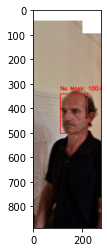

NO MASK (2022-08-19 19:22:35)


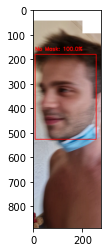

NO MASK (2022-08-19 19:22:46)


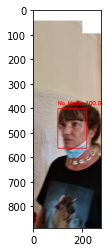

NO MASK (2022-08-19 19:22:49)


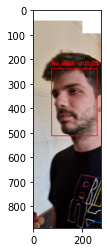

NO MASK (2022-08-19 19:23:06)


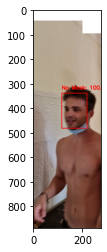

NO MASK (2022-08-19 19:23:08)


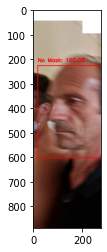

NO MASK (2022-08-19 19:23:12)


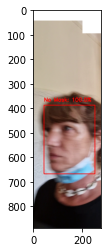

NO MASK (2022-08-19 19:23:14)


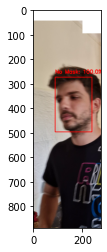

MASK (2022-08-19 19:23:31)


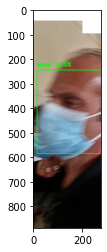

MASK (2022-08-19 19:23:37)


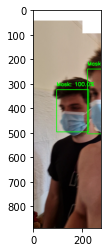

MASK (2022-08-19 19:23:38)


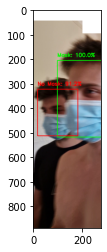

NO MASK (2022-08-19 19:23:56)


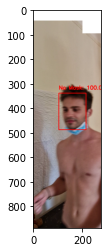

MASK (2022-08-19 19:23:59)


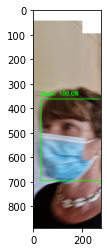

NO MASK (2022-08-19 19:24:02)


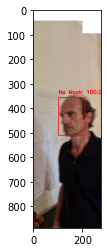

MASK (2022-08-19 19:24:05)


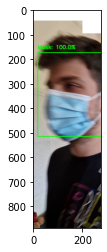

15 people.
5 mask.
10 no_mask.
0 uncertain.


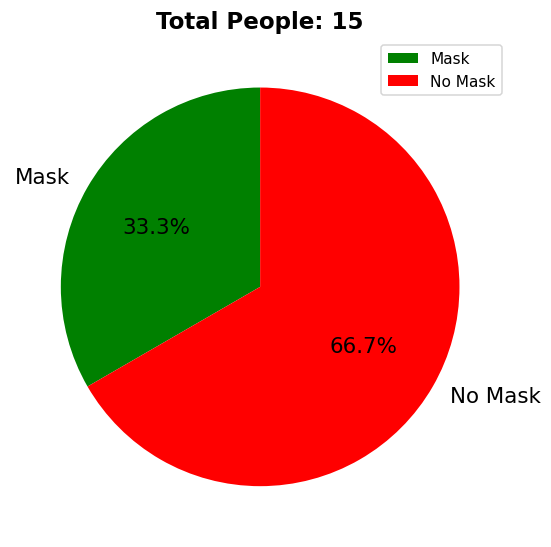

In [11]:
tracker = TrackerCounter()
print('Test 4: MULTIPLE')
vs = FileVideoStream('4_multiple.mp4').start()

# Initialise total tracked faces to 0 
idd = 0


W = 500
left_boundary_line = int(0.35*W)

# Count fps initialise
fps_start_time = 0
fps = 0

# initialise csv file with collected data
detection_data = []


# loop over the frames from the video stream
while True:
    
    frame = vs.read()
    
    # ONLY FOR VIDEO FILES: check if video file has ended has ended
    if type(frame).__module__!= 'numpy':
        break
    
    
    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''
    
    # Resize the frame
    # NB: cv2.resize lets you choose height and width, imutils.resize only lets you choose width but preserves ratio
    # frame = cv2.resize(frame, dsize=(x, y))
    
    frame = imutils.resize(frame, width=W)
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    H, W = frame.shape[:2] # used in detect_and_classify also
    
    
    # Calculate ideal font scale
    scale = 0.030                      # this value can be from 0 to 1 (0,1] to change the size of the text relative to the image
    ideal_font_size = min(W,H)/(25/scale)
    
    # Define box locations
    yy = int(ideal_font_size*35)
    box1start = np.array((0, 0))
    box1end = np.array((int(0.40*W), yy*2))
    box2start = np.array((int(0.40*W), 0))
    box2end = np.array((W, int(yy*4.5)))
    
    cv2.rectangle(frame, pt1=box1start, pt2=box1end, color=(255, 255, 255), thickness=-1)
    cv2.rectangle(frame, pt1=box2start, pt2=box2end, color=(255, 255, 255), thickness=-1)
    
    # TODO: add border to box 

    
    '''
    DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY 
    DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY 
    '''
    
    # Detect and Classify for each frame
    locs, preds, rects = detect_and_classify(frame, detector, classifier)

    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''
    
    label_probs = [] # This is for tracker_counter to average over multiple classifications
    # Live Counter
    num_of_masked = 0
    num_of_unmasked = 0
    num_of_uncertain = 0
    
    # Define classification uncertainty interval
    uncertain_interval = 0. # 0.1 is 10% so 40-60 
    
    # loop over face locations and mask predictions
    for box, pred in zip(locs, preds):
        
        # unpack the bounding box and predictions
        startX, startY, endX, endY = box
        mask, no_mask = pred
        
        # 1. Determine the class label 2. Add colour (BGR)
        if mask >= 0.5 + uncertain_interval:
            label = 'Mask'
            colour = (0, 255, 0)
            num_of_masked +=1
            label_probs.append(mask)
            
        elif no_mask >= 0.5 + uncertain_interval:
            label = 'No Mask'
            colour = (0, 0, 255)
            num_of_unmasked +=1
            label_probs.append(-no_mask)
            
        elif (mask >= 0.5) and (mask <= 0.5 + uncertain_interval):
            label = 'Uncertain'
            colour = (0, 255, 255)
            num_of_uncertain +=1
            # for tracker_counter to average over 
            label_probs.append(mask)
            
        elif (no_mask >= 0.5) and (no_mask <= 0.5 + uncertain_interval):
            label = 'Uncertain'
            colour = (0, 255, 255)
            num_of_uncertain +=1
            # for tracker_counter to average over 
            label_probs.append(-no_mask)
        
        # probability and text to display
        probability = max(mask, no_mask) * 100
        label_text = f'{label}: {probability:.1f}%'
        
        
        # 1. Display label  
        cv2.putText(img=frame, text=label_text, org=(startX, startY - 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=colour, thickness=2)
        # 2. Display bounding box
        cv2.rectangle(img=frame, pt1=(startX, startY), pt2=(endX, endY), color=colour, thickness=2)
        

    '''
    COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER
    COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER 
    '''
    
    
    # objects_info = [object1_info, object2_info, ...] where object_info = [Xstart, Ystart, Xend, Yend, id_of_object]
    objects_info = tracker.update(rects, label_probs, W, H, dist_same_obj=(W + H / 14))
        
        
    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''  
    
    # for all objects
    for object_info in objects_info: 
        Xstart, Ystart, Xend, Yend, idd = object_info
        
        # VISUALS        
        # Text
        # ID of face (TODO: get rid of this eventually)
        cv2.putText(img=frame, text=f'Face {idd}', org=(Xstart, Ystart-40), fontScale=1.4, fontFace=cv2.FONT_HERSHEY_PLAIN, color=(155, 149, 24), thickness=2)
    
    
    # Calculate fps
    fps_end_time = time.time()
    time_diff = fps_end_time - fps_start_time
    fps = int(1/time_diff)
    fps = f'FPS: {fps}'
    fps_start_time = fps_end_time
    
    # Calculate current time
    current_time = str(datetime.now())[:-7]
    
    # VISUALS: Display FPS and Current Time
    # TODO: Get rid of this eventually.Think of potential use cases
    cv2.putText(img=frame, text=current_time, org=(box1start[0] + box1start[0]//14, yy), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=2)
    cv2.putText(img=frame, text=fps, org=(box1start[0] + box1start[0]//14, int(yy*1.8)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=2)
    
    # VISUALS: Display boundary line
    cv2.line(img=frame, pt1=(left_boundary_line, 0), pt2=(left_boundary_line, H), color=(45, 174, 102), thickness=5) 
    
    # VISUALS: Display live people counter 
    cv2.putText(img=frame, text=f'People Count: {tracker.people_count}', org=(box2start[0] + box2start[0]//15, yy), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 0, 0), thickness=2)
    percent_masked = 0
    percent_unmasked = 0
    percent_uncertain = 0
    if tracker.people_count != 0:
        percent_masked = np.round(tracker.mask_count / tracker.people_count * 100, 1) 
        percent_unmasked = np.round(tracker.nomask_count / tracker.people_count * 100, 1) 
        percent_uncertain = np.round(tracker.uncertain_count / tracker.people_count * 100, 1) 
    cv2.putText(img=frame, text=f'Masked:       {tracker.mask_count} ({percent_masked}%)', org=(box2start[0] + box2start[0]//15, yy*2), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 155, 0), thickness=2)
    cv2.putText(img=frame, text=f'Unmasked:    {tracker.nomask_count} ({percent_unmasked}%)', org=(box2start[0] + box2start[0]//15, int(yy*3)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 0, 155), thickness=2)
    cv2.putText(img=frame, text=f'Uncertain:     {tracker.uncertain_count} ({percent_uncertain}%)', org=(box2start[0] + box2start[0]//15, int(yy*4)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 155, 155), thickness=2)

    '''
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    '''
            
    # Show the output frame in real-time
    cv2.imshow("Frame", frame)

    # Terminate if `q` is pressed. waitKey(0): keeps image still until a key is pressed. waitKey(x) it will wait x miliseconds each frame
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
        
''' 
EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS 
EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS 
'''

        

'''Export csv file and summarise results'''
detection_data = pd.DataFrame(data=detection_data, columns=['Label', 'Datetime'])
detection_data.to_csv('detection_data.csv', index=False)

# Summarise and visualise results
num_of_people = detection_data.shape[0]
if num_of_people > 0:
    mask = detection_data[detection_data.Label == 'mask'].shape[0]
    no_mask = detection_data[detection_data.Label == 'no_mask'].shape[0]
    uncertain = detection_data[detection_data.Label == 'uncertain'].shape[0]

    print(f'{num_of_people} people.')
    print(f'{mask} mask.')
    print(f'{no_mask} no_mask.')
    print(f'{uncertain} uncertain.')


    # PIE CHART
    dpi=110
    fig = plt.figure(figsize=(8, 6), dpi=dpi)

    if uncertain != 0:
        plt.pie(x=[mask, no_mask, uncertain], labels=['Mask', 'No Mask', 'Uncertain'], colors=['green', 'red', 'yellow'], startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14})
    if uncertain == 0: 
        plt.pie(x=[mask, no_mask], labels=['Mask', 'No Mask'], colors=['green', 'red'], startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14})

    plt.title(f'Total People: {num_of_people}', fontweight='bold', fontsize=15)
    plt.legend()
    plt.show()

    fig.savefig(f'face_covering_pie_chart.png', dpi = dpi)

else:
    print('No people detected.')

        
# # Cleanup
#vs.stop()
#cv2.destroyAllWindows()


Test 5: REALISTIC CHAOS
MASK (2022-08-19 19:24:19)


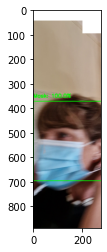

MASK (2022-08-19 19:24:24)


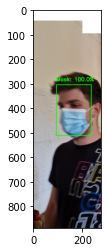

NO MASK (2022-08-19 19:24:42)


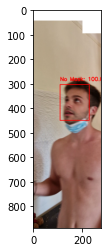

MASK (2022-08-19 19:24:46)


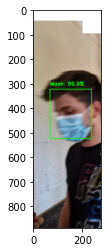

MASK (2022-08-19 19:25:10)


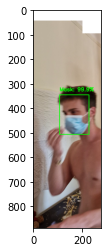

UNCERTAIN (2022-08-19 19:25:17)


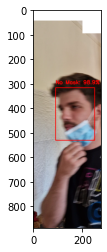

MASK (2022-08-19 19:25:20)


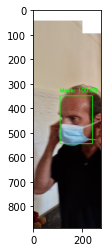

NO MASK (2022-08-19 19:25:38)


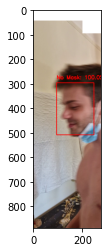

MASK (2022-08-19 19:25:45)


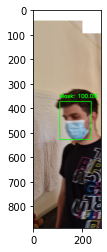

NO MASK (2022-08-19 19:25:52)


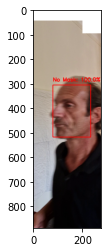

10 people.
6 mask.
3 no_mask.
1 uncertain.


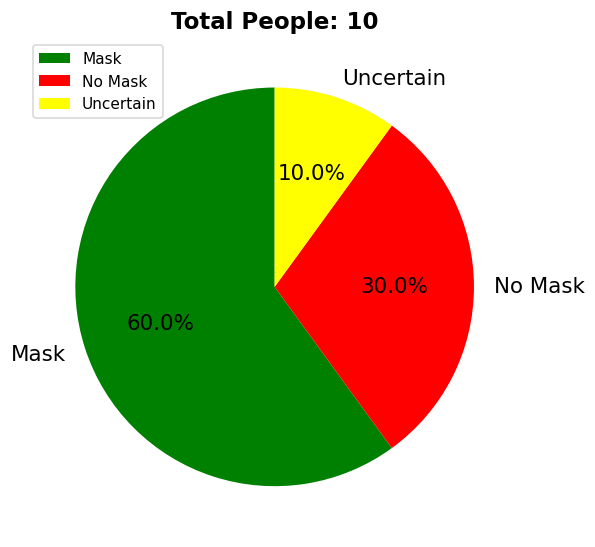

In [12]:
tracker = TrackerCounter()
print('Test 5: REALISTIC CHAOS')
vs = FileVideoStream('5_realistic_chaos.mp4').start()
# Initialise total tracked faces to 0 
idd = 0


W = 500
left_boundary_line = int(0.35*W)

# Count fps initialise
fps_start_time = 0
fps = 0

# initialise csv file with collected data
detection_data = []


# loop over the frames from the video stream
while True:
    
    frame = vs.read()
    
    # ONLY FOR VIDEO FILES: check if video file has ended has ended
    if type(frame).__module__!= 'numpy':
        break
    
    
    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''
    
    # Resize the frame
    # NB: cv2.resize lets you choose height and width, imutils.resize only lets you choose width but preserves ratio
    # frame = cv2.resize(frame, dsize=(x, y))
    
    frame = imutils.resize(frame, width=W)
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    H, W = frame.shape[:2] # used in detect_and_classify also
    
    
    # Calculate ideal font scale
    scale = 0.030                      # this value can be from 0 to 1 (0,1] to change the size of the text relative to the image
    ideal_font_size = min(W,H)/(25/scale)
    
    # Define box locations
    yy = int(ideal_font_size*35)
    box1start = np.array((0, 0))
    box1end = np.array((int(0.40*W), yy*2))
    box2start = np.array((int(0.40*W), 0))
    box2end = np.array((W, int(yy*4.5)))
    
    cv2.rectangle(frame, pt1=box1start, pt2=box1end, color=(255, 255, 255), thickness=-1)
    cv2.rectangle(frame, pt1=box2start, pt2=box2end, color=(255, 255, 255), thickness=-1)
    
    # TODO: add border to box 

    
    '''
    DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY 
    DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY DETECT & CLASSIFY 
    '''
    
    # Detect and Classify for each frame
    locs, preds, rects = detect_and_classify(frame, detector, classifier)

    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''
    
    label_probs = [] # This is for tracker_counter to average over multiple classifications
    # Live Counter
    num_of_masked = 0
    num_of_unmasked = 0
    num_of_uncertain = 0
    
    # Define classification uncertainty interval
    uncertain_interval = 0. # 0.1 is 10% so 40-60 
    
    # loop over face locations and mask predictions
    for box, pred in zip(locs, preds):
        
        # unpack the bounding box and predictions
        startX, startY, endX, endY = box
        mask, no_mask = pred
        
        # 1. Determine the class label 2. Add colour (BGR)
        if mask >= 0.5 + uncertain_interval:
            label = 'Mask'
            colour = (0, 255, 0)
            num_of_masked +=1
            label_probs.append(mask)
            
        elif no_mask >= 0.5 + uncertain_interval:
            label = 'No Mask'
            colour = (0, 0, 255)
            num_of_unmasked +=1
            label_probs.append(-no_mask)
            
        elif (mask >= 0.5) and (mask <= 0.5 + uncertain_interval):
            label = 'Uncertain'
            colour = (0, 255, 255)
            num_of_uncertain +=1
            # for tracker_counter to average over 
            label_probs.append(mask)
            
        elif (no_mask >= 0.5) and (no_mask <= 0.5 + uncertain_interval):
            label = 'Uncertain'
            colour = (0, 255, 255)
            num_of_uncertain +=1
            # for tracker_counter to average over 
            label_probs.append(-no_mask)
        
        # probability and text to display
        probability = max(mask, no_mask) * 100
        label_text = f'{label}: {probability:.1f}%'
        
        
        # 1. Display label  
        cv2.putText(img=frame, text=label_text, org=(startX, startY - 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=colour, thickness=2)
        # 2. Display bounding box
        cv2.rectangle(img=frame, pt1=(startX, startY), pt2=(endX, endY), color=colour, thickness=2)
        

    '''
    COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER
    COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER COUNTER_TRACKER 
    '''
    
    
    # objects_info = [object1_info, object2_info, ...] where object_info = [Xstart, Ystart, Xend, Yend, id_of_object]
    objects_info = tracker.update(rects, label_probs, W, H, dist_same_obj=(W + H / 14))
        
        
    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS
    '''  
    
    # for all objects
    for object_info in objects_info: 
        Xstart, Ystart, Xend, Yend, idd = object_info
        
        # VISUALS        
        # Text
        # ID of face (TODO: get rid of this eventually)
        cv2.putText(img=frame, text=f'Face {idd}', org=(Xstart, Ystart-40), fontScale=1.4, fontFace=cv2.FONT_HERSHEY_PLAIN, color=(155, 149, 24), thickness=2)
    
    
    # Calculate fps
    fps_end_time = time.time()
    time_diff = fps_end_time - fps_start_time
    fps = int(1/time_diff)
    fps = f'FPS: {fps}'
    fps_start_time = fps_end_time
    
    # Calculate current time
    current_time = str(datetime.now())[:-7]
    
    # VISUALS: Display FPS and Current Time
    # TODO: Get rid of this eventually.Think of potential use cases
    cv2.putText(img=frame, text=current_time, org=(box1start[0] + box1start[0]//14, yy), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=2)
    cv2.putText(img=frame, text=fps, org=(box1start[0] + box1start[0]//14, int(yy*1.8)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=2)
    
    # VISUALS: Display boundary line
    cv2.line(img=frame, pt1=(left_boundary_line, 0), pt2=(left_boundary_line, H), color=(45, 174, 102), thickness=5) 
    
    # VISUALS: Display live people counter 
    cv2.putText(img=frame, text=f'People Count: {tracker.people_count}', org=(box2start[0] + box2start[0]//15, yy), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 0, 0), thickness=2)
    percent_masked = 0
    percent_unmasked = 0
    percent_uncertain = 0
    if tracker.people_count != 0:
        percent_masked = np.round(tracker.mask_count / tracker.people_count * 100, 1) 
        percent_unmasked = np.round(tracker.nomask_count / tracker.people_count * 100, 1) 
        percent_uncertain = np.round(tracker.uncertain_count / tracker.people_count * 100, 1) 
    cv2.putText(img=frame, text=f'Masked:       {tracker.mask_count} ({percent_masked}%)', org=(box2start[0] + box2start[0]//15, yy*2), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 155, 0), thickness=2)
    cv2.putText(img=frame, text=f'Unmasked:    {tracker.nomask_count} ({percent_unmasked}%)', org=(box2start[0] + box2start[0]//15, int(yy*3)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 0, 155), thickness=2)
    cv2.putText(img=frame, text=f'Uncertain:     {tracker.uncertain_count} ({percent_uncertain}%)', org=(box2start[0] + box2start[0]//15, int(yy*4)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=ideal_font_size, color=(0, 155, 155), thickness=2)

    '''
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM END STREAM 
    '''
            
    # Show the output frame in real-time
    cv2.imshow("Frame", frame)

    # Terminate if `q` is pressed. waitKey(0): keeps image still until a key is pressed. waitKey(x) it will wait x miliseconds each frame
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
        
''' 
EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS 
EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS EXPORT RESULTS 
'''

        

'''Export csv file and summarise results'''
detection_data = pd.DataFrame(data=detection_data, columns=['Label', 'Datetime'])
detection_data.to_csv('detection_data.csv', index=False)

# Summarise and visualise results
num_of_people = detection_data.shape[0]
if num_of_people > 0:
    mask = detection_data[detection_data.Label == 'mask'].shape[0]
    no_mask = detection_data[detection_data.Label == 'no_mask'].shape[0]
    uncertain = detection_data[detection_data.Label == 'uncertain'].shape[0]

    print(f'{num_of_people} people.')
    print(f'{mask} mask.')
    print(f'{no_mask} no_mask.')
    print(f'{uncertain} uncertain.')


    # PIE CHART
    dpi=110
    fig = plt.figure(figsize=(8, 6), dpi=dpi)

    if uncertain != 0:
        plt.pie(x=[mask, no_mask, uncertain], labels=['Mask', 'No Mask', 'Uncertain'], colors=['green', 'red', 'yellow'], startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14})
    if uncertain == 0: 
        plt.pie(x=[mask, no_mask], labels=['Mask', 'No Mask'], colors=['green', 'red'], startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14})

    plt.title(f'Total People: {num_of_people}', fontweight='bold', fontsize=15)
    plt.legend()
    plt.show()

    fig.savefig(f'face_covering_pie_chart.png', dpi = dpi)

else:
    print('No people detected.')

        
# # Cleanup
#vs.stop()
#cv2.destroyAllWindows()


### 🔴 7. Results

In [13]:
fig.savefig(f'({detection_data.iloc[0][1].split()[0]}_{detection_data.iloc[0][1].split()[1]})_face_covering_pie_chart.png', dpi = dpi)

OSError: [Errno 22] Invalid argument: '(2022-08-19_19:24:19)_face_covering_pie_chart.png'

In [ ]:
detection_data.iloc[0][1].split()[1].replace(':', '.')